In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from sklearn.datasets import fetch_openml

import online_utils as utils

plt.style.use('default')
plt.rcParams["text.usetex"] = True
np.random.seed(14159)

# Set parameters

In [2]:
X, y = fetch_openml('Fashion-MNIST', return_X_y=True)
X, y = X.values, y.values.astype(int)
num_classes = {0: "T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat", 5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle boot"}

In [3]:
n = 1000
L = 100

classes = [4, 9]
k = len(classes)

mask = np.zeros(y.shape[0], dtype=bool)
for j in classes:
    mask |= (y == j)
Xc, yc = X[mask], y[mask]
Xc -= np.mean(Xc, axis=0) # centering
for i, j in enumerate(np.sort(classes)):
    yc[yc == j] = i
T, p = Xc.shape

idx = np.arange(T)
np.random.shuffle(idx)
Xc, yc = Xc[idx], yc[idx]

get_data = lambda t: Xc[t]

setting = "$T = {} \quad n = {} \quad p = {} \quad L = {}$".format(T, n, p, L)

# Streaming

In [4]:
class_count, (lbda, w, partition_ite, time_ite) = utils.pm1_streaming(get_data, T, n, p, L, k)

100%|██████████| 14000/14000 [17:32<00:00, 13.30it/s]


In [5]:
# Estimate classes via majority vote
partition = np.argmax(class_count, axis=1)

# Results

In [6]:
# Get classification error
c_err, per, per_inv = utils.get_classif_error(k, partition, yc)
print("Classification error: {:.2%}".format(c_err))

# Compute classification error vs. delay
delay_c_err = np.mean(per[partition_ite[n-1:]] != np.array([yc[t:t+n] for t in range(T-n+1)]), axis=0)[::-1]

Classification error: 3.29%


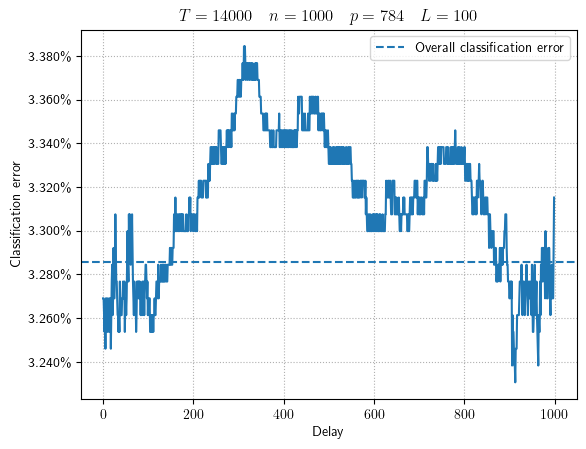

In [7]:
plt.plot(delay_c_err)
plt.axhline(y=c_err, ls='--', label="Overall classification error")
plt.grid(ls=':')
plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=1))
plt.xlabel("Delay")
plt.ylabel("Classification error")
plt.title(setting)
plt.legend()
plt.show()

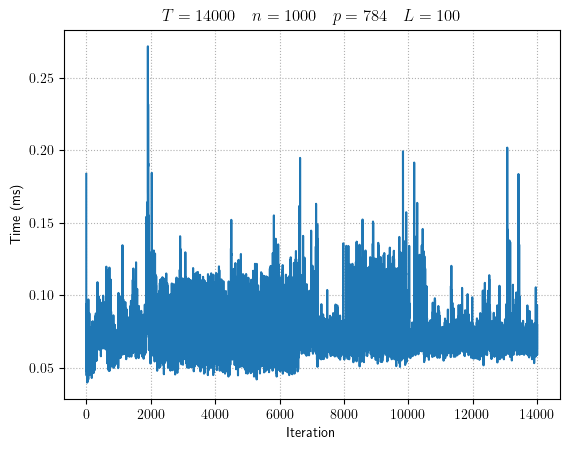

In [8]:
plt.plot(time_ite)
plt.grid(ls=':')
plt.xlabel("Iteration")
plt.ylabel("Time (ms)")
plt.title(setting)
plt.show()

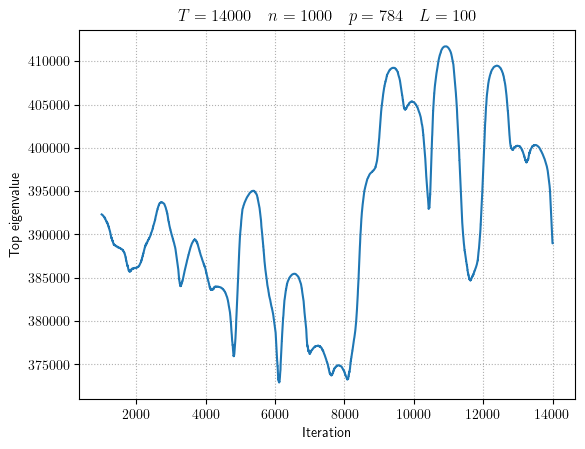

In [9]:
plt.plot(lbda)
plt.grid(ls=':')
plt.xlabel("Iteration")
plt.ylabel("Top eigenvalue")
plt.title(setting)
plt.show()

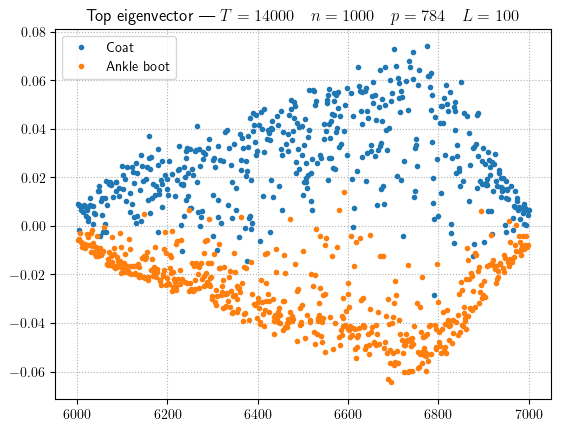

In [10]:
t = T//2

x = np.arange(max(0, t-n+1), max(n, t+1))
for j in range(k):
    color = 'C'+str(j)
    cl = (yc[max(0, t-n+1):t+1] == j)
    cl = np.append(cl, np.zeros(max(0, n-t-1), dtype=bool))
    plt.plot(x[cl], w[t, cl], ls='', marker='.', c=color, label=num_classes[classes[j]], zorder=2)
plt.grid(ls=':')
plt.title("Top eigenvector | "+setting)
plt.legend()
plt.show()